# Import

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Layer, Multiply, Permute, Flatten, RepeatVector, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import joblib
from sklearn.model_selection import train_test_split
from datetime import timedelta
from collections import Counter
import glob

# About Dataset
- Sample Rate = 125Hz
- Duration = 1200 seconds (20 mins)
- AF = 19 patients (mimic_perform_af_001 to mimic_perform_af_019)
- Non-AF = 16 patients (mimic_perform_non_af_001 to mimic_perform_non_af_016)
- n_data per patient = 150,000 (after removing row 150,001)
- Data source: Separate folders for AF and non-AF patients
- **This notebook uses ECG signal only (PPG and resp are dropped)**

## Arsitektur Model (Based on Journal)
1. **Feature Extraction**: 5 statistical features per window (Skewness, Kurtosis, Min, Max, STD)
2. **Attention-based LSTM**: 5 layers, nhidden=30, with Softmax attention
3. **XGBoost Classifier**: Grid Search optimization for final classification

## Path

In [2]:
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir))
af_folder = os.path.join(project_root, 'Data', 'af')
nonaf_folder = os.path.join(project_root, 'Data', 'non-af')

af_files = sorted(glob.glob(os.path.join(af_folder, '*.csv')))[:19]
nonaf_files = sorted(glob.glob(os.path.join(nonaf_folder, '*.csv')))[:16]

## Train Test Split

In [3]:
test_af = af_files[-3:]        
val_af = af_files[-6:-3]       
train_af = af_files[:-6]       

test_nonaf = nonaf_files[-3:]  
val_nonaf = nonaf_files[-6:-3] 
train_nonaf = nonaf_files[:-6]

## Load Dataset

In [4]:
def load(files, status):
    arr = []
    for f in files:
        df = pd.read_csv(f)
        if len(df) > 150000:
            df = df.iloc[:150000]
        df['status'] = status
        arr.append(df)
    return arr

test_af_data = load(test_af, 1)
val_af_data = load(val_af, 1)
train_af_data = load(train_af, 1)

test_nonaf_data = load(test_nonaf, 0)
val_nonaf_data = load(val_nonaf, 0)
train_nonaf_data = load(train_nonaf, 0)

test = pd.concat(test_af_data + test_nonaf_data, ignore_index=True)
val = pd.concat(val_af_data + val_nonaf_data, ignore_index=True)
train = pd.concat(train_af_data + train_nonaf_data, ignore_index=True)
df = pd.concat([train, val, test], ignore_index=True)
df

,Time,PPG,ECG,resp,status
0,0.000,0.537634,0.425781,-0.029340,1
1,0.008,0.534702,0.404297,-0.036675,1
2,0.016,0.531769,0.400391,-0.044010,1
3,0.024,0.528837,0.400391,-0.053790,1
4,0.032,0.524927,0.419922,-0.061125,1
...,...,...,...,...,...
5249995,1199.960,2.270772,0.325024,0.018447,0
5249996,1199.968,2.266862,0.339687,0.024272,0
5249997,1199.976,2.259042,0.365103,0.030097,0
5249998,1199.984,2.248289,0.374878,0.035437,0


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250000 entries, 0 to 5249999
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    float64
 1   PPG     float64
 2   ECG     float64
 3   resp    float64
 4   status  int64  
dtypes: float64(4), int64(1)
memory usage: 200.3 MB


In [6]:
df.describe()

,Time,PPG,ECG,resp,status
count,5.250000e+06,5.247101e+06,5.249625e+06,3.900000e+06,5.250000e+06
mean,5.999960e+02,9.497512e-01,4.150872e-01,2.368881e-01,5.428571e-01
std,3.464102e+02,7.359951e-01,2.779200e-01,4.592666e-01,4.981599e-01
min,0.000000e+00,0.000000e+00,-5.019608e-01,-1.846506e+00,0.000000e+00
25%,2.999980e+02,4.078431e-01,2.649071e-01,2.015883e-02,0.000000e+00
50%,5.999960e+02,5.503421e-01,4.257812e-01,2.355816e-01,1.000000e+00
75%,8.999940e+02,1.678397e+00,5.551758e-01,4.686347e-01,1.000000e+00
max,1.199992e+03,4.001955e+00,1.503937e+00,2.844215e+00,1.000000e+00


In [7]:
status_count = df['status'].value_counts()
status_count

status
1    2850000
0    2400000
Name: count, dtype: int64

## Pie chart AF Status

In [8]:
# Pie chart (for percentage)
status = status_count.sort_index()
status_index = status.index
fig = px.pie(names=status_index, values=status, hole=0.3,
             labels={'names':'status'}, title='AF Status Distribution Pie Chart')
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()


In [9]:
df.isna().sum()

Time            0
PPG          2899
ECG           375
resp      1350000
status          0
dtype: int64

In [10]:
df.isna().mean() * 100

Time       0.000000
PPG        0.055219
ECG        0.007143
resp      25.714286
status     0.000000
dtype: float64

## Visualize signal on specific range

In [11]:
def show_wave_from(df, pasien_ke=1, s_start=0, s_stop=10, fitur='ppg', af_status=0, sample_rate=125):
    lama_ukur = 1200 # 20m = 1200s
    sample_per_pasien = lama_ukur * sample_rate
    duration = s_stop - s_start

    if 0 <= s_start <= lama_ukur and 0 <= s_stop <= lama_ukur:
        if af_status == 0 and 1 <= pasien_ke <= 16:
            afdf = df[df['status'] == 0]
        elif af_status == 1 and 1 <= pasien_ke <= 19:
            afdf = df[df['status'] == 1]
        else:
            print('Invalid nomor pasien atau sample time')

        dfpasien = afdf[(pasien_ke - 1) * sample_per_pasien : pasien_ke * sample_per_pasien]
        dfintvl = dfpasien[sample_rate*s_start : (sample_rate*s_stop)+1]
            
        x_ax = dfintvl['Time']
        y_ax = dfintvl[fitur]

        plt.figure(figsize=(16, 4))
        plt.plot(x_ax, y_ax)
        plt.title(f'Gelombang {fitur} dari pasien ke-{pasien_ke} dari {s_start} - {s_stop} detik')

        step = s_start
        for t in range(duration):
            step += 1
            plt.axvline(x=step, color='gray', linestyle='--', linewidth=0.8)

        plt.show()

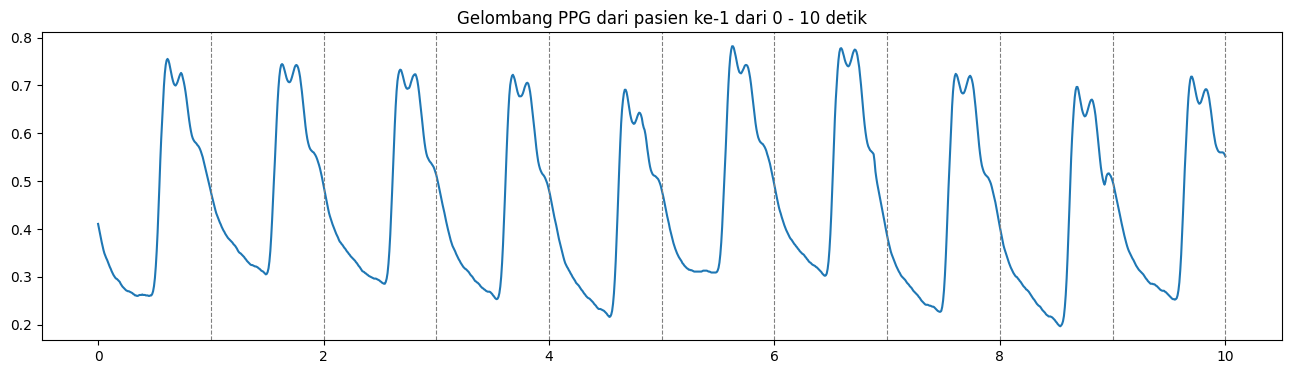

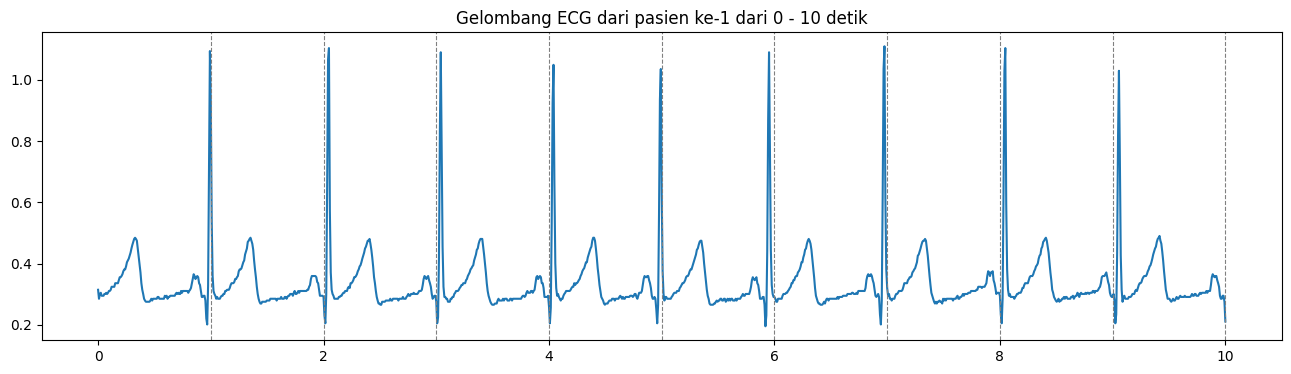

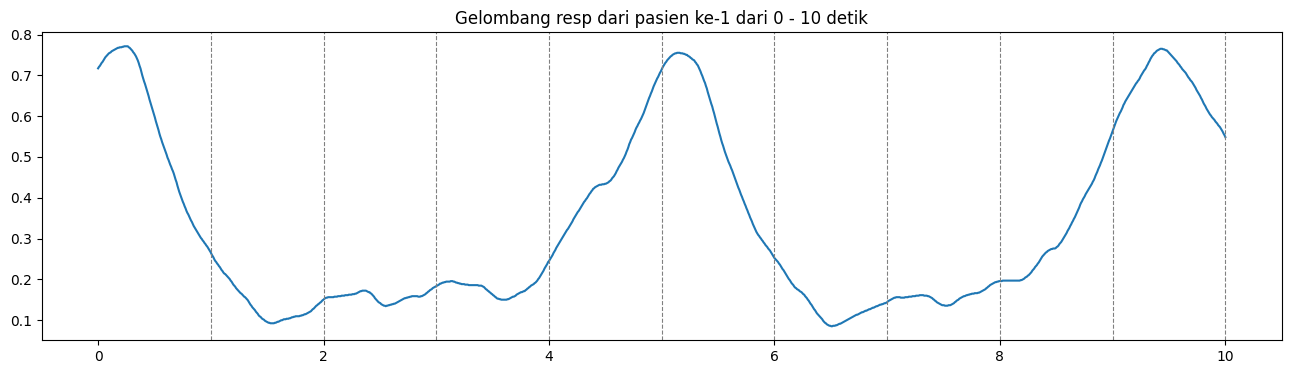

In [12]:
for i in df.columns[1:-1]:
    show_wave_from(df, fitur=i, sample_rate=125)

## AF VS Non-AF Wave

Non-AF Wave:

Feature: PPG


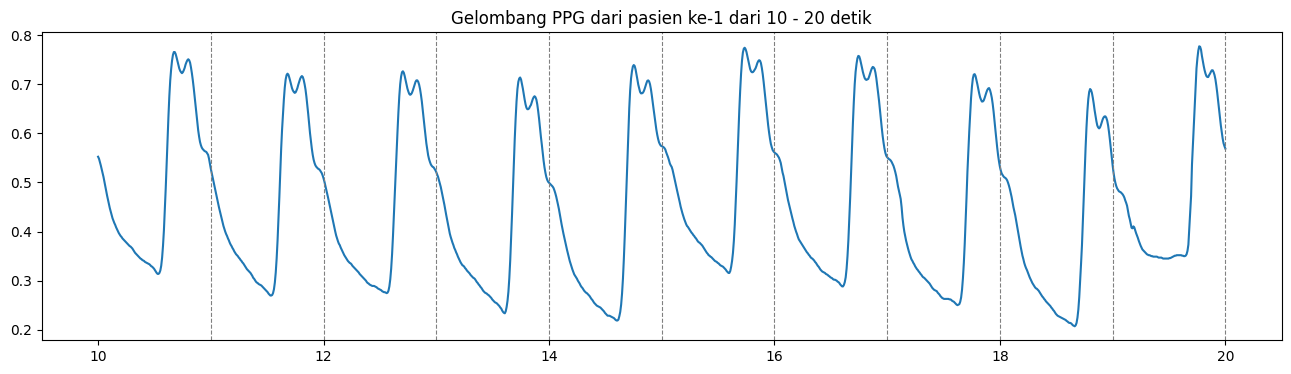


Feature: ECG


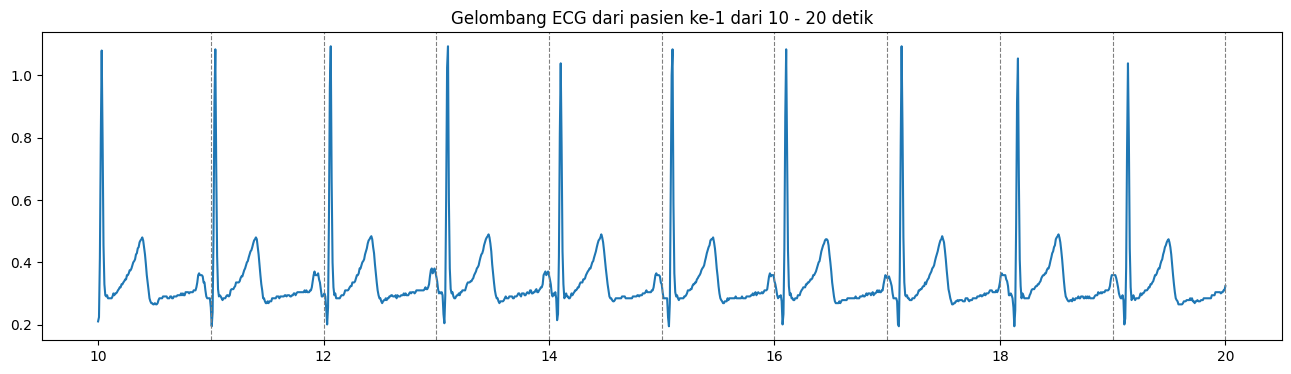


Feature: resp
  Min: 0.0910209102091021
  Max: 0.789667896678967
  Std: 0.20287974798374794
  Unique values: 441
  Min: 0.0910209102091021
  Max: 0.789667896678967
  Std: 0.20287974798374794
  Unique values: 441


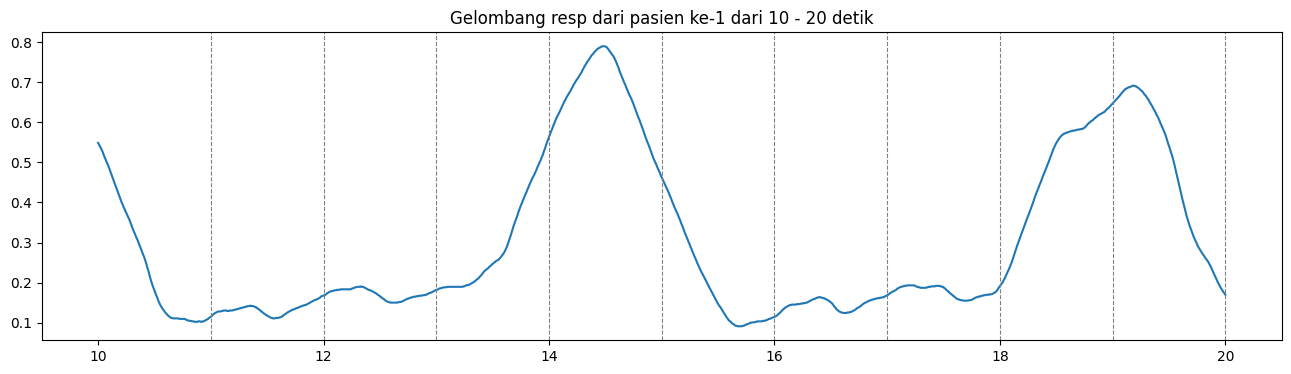


AF Wave:

Feature: PPG


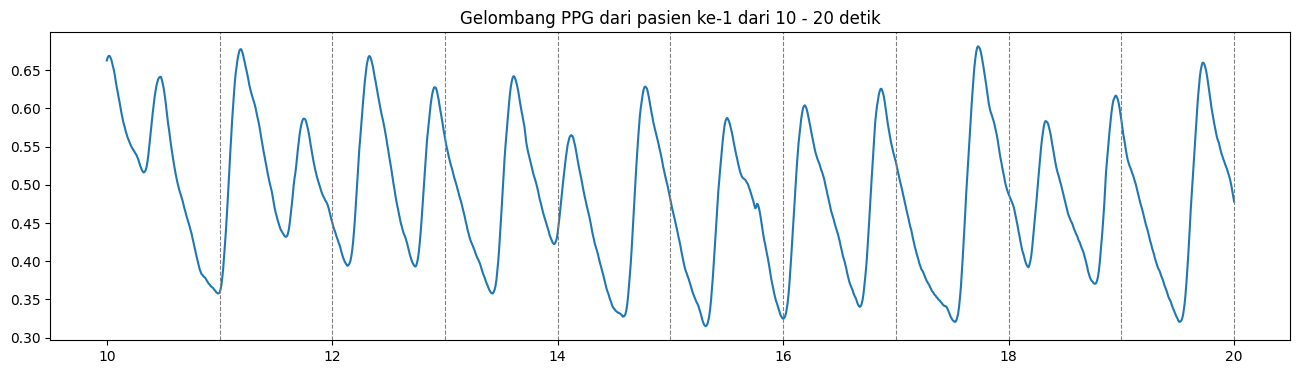


Feature: ECG


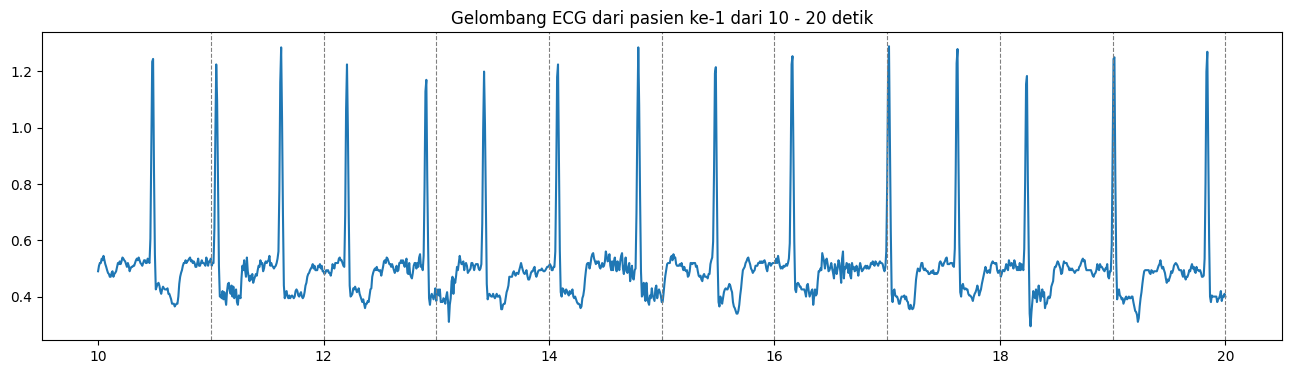


Feature: resp
  Min: -0.339853300733496
  Max: 0.493887530562347
  Std: 0.22667350914833606
  Unique values: 309
  Min: -0.339853300733496
  Max: 0.493887530562347
  Std: 0.22667350914833606
  Unique values: 309


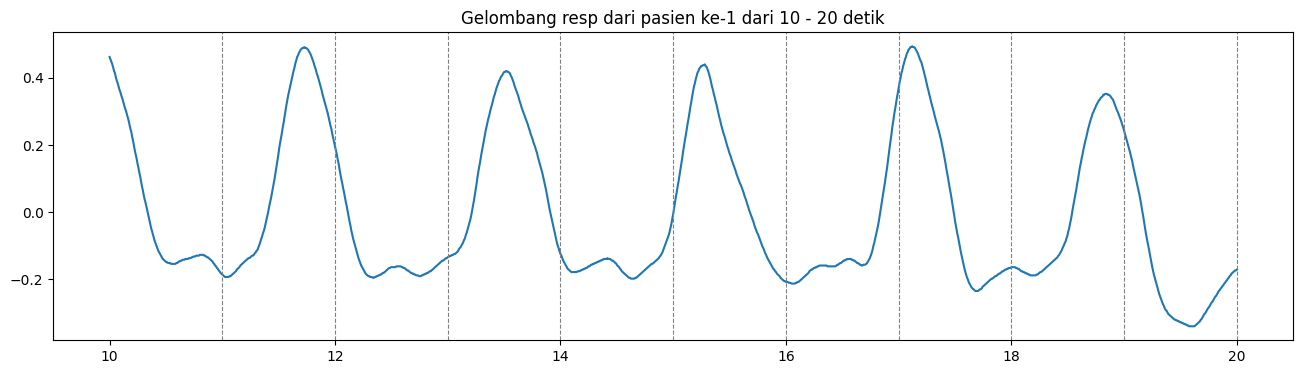

In [13]:
# Check data resp untuk pasien yang dipilih
print('Non-AF Wave:')
for i in df.columns[1:-1]:
    print(f'\nFeature: {i}')
    # Ambil data pasien pertama non-AF
    nonaf_df = df[df['status'] == 0]
    pasien_data = nonaf_df[1250:2500]  # 10-20 detik
    
    # Cek apakah ada variasi di data resp
    if i == 'resp':
        print(f"  Min: {pasien_data[i].min()}")
        print(f"  Max: {pasien_data[i].max()}")
        print(f"  Std: {pasien_data[i].std()}")
        print(f"  Unique values: {pasien_data[i].nunique()}")
    
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=0, fitur=i)

print('\n' + '='*50)
print('AF Wave:')
for i in df.columns[1:-1]:
    print(f'\nFeature: {i}')
    # Ambil data pasien pertama AF
    af_df = df[df['status'] == 1]
    pasien_data = af_df[1250:2500]  # 10-20 detik
    
    # Cek apakah ada variasi di data resp
    if i == 'resp':
        print(f"  Min: {pasien_data[i].min()}")
        print(f"  Max: {pasien_data[i].max()}")
        print(f"  Std: {pasien_data[i].std()}")
        print(f"  Unique values: {pasien_data[i].nunique()}")
    
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=1, fitur=i)

# Praprocessing

## Feature Engineering

In [14]:
train.drop(columns=['resp','PPG'], inplace=True)
test.drop(columns=['resp','PPG'], inplace=True)
val.drop(columns=['resp','PPG'], inplace=True)

## Imputation: Interpolation

In [15]:
train['ECG'] = train['ECG'].interpolate()
train.isna().sum()

Time      0
ECG       0
status    0
dtype: int64

In [16]:
test['ECG'] = test['ECG'].interpolate()
test.isna().sum()

Time      0
ECG       0
status    0
dtype: int64

In [17]:
val['ECG'] = val['ECG'].interpolate()
val.isna().sum()

Time      0
ECG       0
status    0
dtype: int64

## Set Window Size

In [18]:
sampling_rate = 125
window_size = sampling_rate    # 125 segment per window (1 second)
n_statistical_features = 5  # Skewness, Kurtosis, Min, Max, STD

def extract_statistical_features(window):
    """
    Extract 5 statistical features from ECG window:
    1. Skewness
    2. Kurtosis
    3. Minimum
    4. Maximum
    5. Standard Deviation (STD)
    """
    features = [
        skew(window),           # Skewness
        kurtosis(window),       # Kurtosis
        np.min(window),         # Minimum
        np.max(window),         # Maximum
        np.std(window)          # Standard Deviation
    ]
    return np.array(features)

def create_windows_with_features(data):
    """Create windows from ECG signal and extract 5 statistical features"""
    ecg_signal = data['ECG'].values
    n_windows = len(ecg_signal) // window_size
    
    features_list = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        ecg_window = ecg_signal[start:end]
        
        # Extract 5 statistical features from each window
        window_features = extract_statistical_features(ecg_window)
        features_list.append(window_features)
    
    # Convert to array: shape will be (n_windows, 5)
    features_array = np.array(features_list)
    print(f"Features shape: {features_array.shape}")
    print(f"Features: [Skewness, Kurtosis, Min, Max, STD]")
    
    # Create DataFrame with named columns
    df_features = pd.DataFrame(features_array, columns=['Skewness', 'Kurtosis', 'Min', 'Max', 'STD'])
    return df_features, n_windows

# Create windows and extract features for train, test, and validation
df_features_train, n_windows_train = create_windows_with_features(train)
df_features_test, n_windows_test = create_windows_with_features(test)
df_features_val, n_windows_val = create_windows_with_features(val)

print(f"\nTrain windows: {n_windows_train}")
print(f"Test windows: {n_windows_test}")
print(f"Validation windows: {n_windows_val}")

# Combined features for compatibility
df_features = pd.concat([df_features_train, df_features_test, df_features_val], ignore_index=True)
n_windows = n_windows_train + n_windows_test + n_windows_val

print(f"\nTotal windows: {n_windows}")
df_features

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23832\1436049496.py:15: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23832\1436049496.py:16: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



Features shape: (27600, 5)
Features: [Skewness, Kurtosis, Min, Max, STD]
Features shape: (7200, 5)
Features: [Skewness, Kurtosis, Min, Max, STD]
Features shape: (7200, 5)
Features: [Skewness, Kurtosis, Min, Max, STD]
Features shape: (7200, 5)
Features: [Skewness, Kurtosis, Min, Max, STD]

Train windows: 27600
Test windows: 7200
Validation windows: 7200

Total windows: 42000
Features shape: (7200, 5)
Features: [Skewness, Kurtosis, Min, Max, STD]

Train windows: 27600
Test windows: 7200
Validation windows: 7200

Total windows: 42000


,Skewness,Kurtosis,Min,Max,STD
0,4.250210,23.529741,0.365234,1.183594,0.107806
1,4.394443,24.138122,0.375000,1.218750,0.106636
2,3.335449,12.016195,0.310547,1.234375,0.150508
3,3.075195,10.396506,0.335938,1.224609,0.153962
4,4.458540,23.989520,0.355469,1.279297,0.115997
...,...,...,...,...,...
41995,3.665183,16.163737,0.404297,1.294922,0.121028
41996,4.259647,26.509674,0.394531,1.263672,0.090619
41997,3.550613,15.598875,0.384766,1.343750,0.129493
41998,3.728378,16.374472,0.419922,1.375000,0.127875


In [19]:
# Jumlah fitur per window
print(f"Number of features per window: {len(df_features.columns)}")
print(f"Feature names: {list(df_features.columns)}")
df_features.describe()

Number of features per window: 5
Feature names: ['Skewness', 'Kurtosis', 'Min', 'Max', 'STD']


,Skewness,Kurtosis,Min,Max,STD
count,41999.000000,41999.000000,42000.000000,42000.000000,4.200000e+04
mean,1.355914,11.238302,0.089752,1.046383,1.582579e-01
std,2.636642,7.615597,0.315790,0.356614,8.068871e-02
min,-11.045726,-2.000000,-0.501961,-0.129310,2.775558e-17
25%,-0.824203,4.857099,-0.157480,0.764778,1.031549e-01
50%,2.189786,10.167134,0.125000,1.070312,1.386921e-01
75%,3.380879,16.346110,0.305176,1.369141,1.870654e-01
max,7.472672,120.008065,1.130542,1.503937,9.170058e-01


### Visualisasi

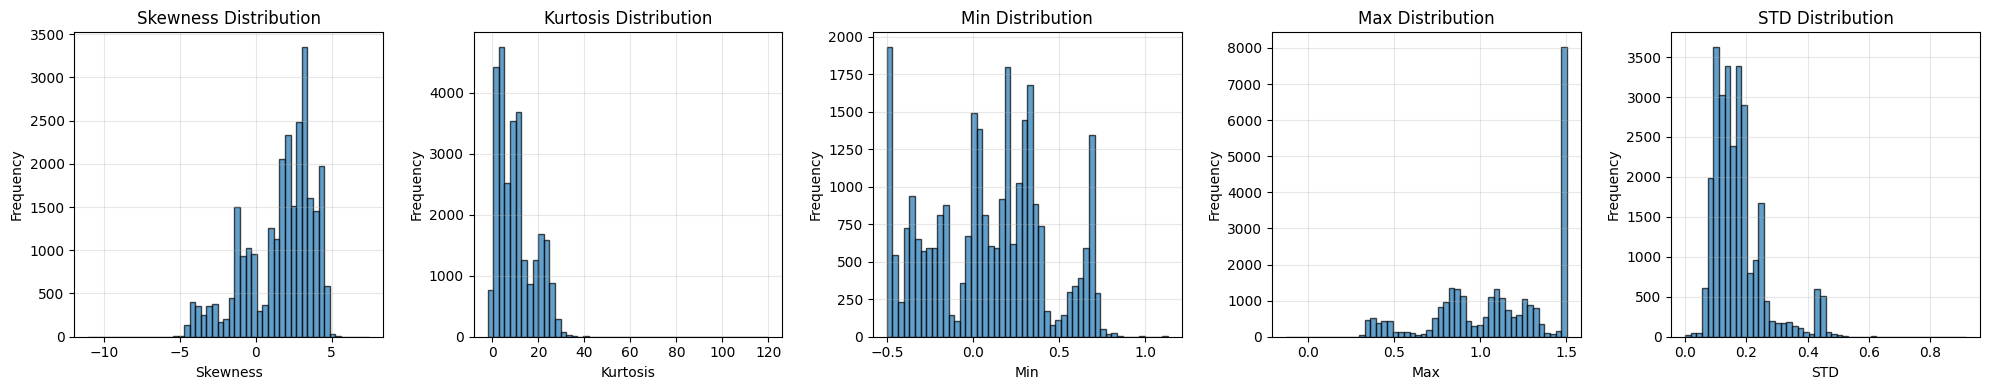

In [20]:
# Visualize feature distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
feature_names = ['Skewness', 'Kurtosis', 'Min', 'Max', 'STD']

for idx, (col, ax) in enumerate(zip(feature_names, axes)):
    ax.hist(df_features_train[col], bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Add Label

In [21]:
train_status = train['status'].values
test_status = test['status'].values
val_status = val['status'].values

train_labels = []
for i in range(n_windows_train):
    start = i * window_size
    end = start + window_size
    window_status = train_status[start:end]
    label = mode(window_status, keepdims=False).mode
    train_labels.append(label)

test_labels = []
for i in range(n_windows_test):
    start = i * window_size
    end = start + window_size
    window_status = test_status[start:end]
    label = mode(window_status, keepdims=False).mode
    test_labels.append(label)

val_labels = []
for i in range(n_windows_val):
    start = i * window_size
    end = start + window_size
    window_status = val_status[start:end]
    label = mode(window_status, keepdims=False).mode
    val_labels.append(label)

df_label_train = pd.Series(train_labels)
df_label_test = pd.Series(test_labels)
df_label_val = pd.Series(val_labels)


df_label = pd.concat([df_label_train, df_label_test, df_label_val], ignore_index=True)

print(f"Train labels: {len(df_label_train)}")
print(f"Test labels: {len(df_label_test)}")
print(f"Validation Labels: {len(df_label_val)}")
print(f"Total labels: {len(df_label)}")
df_label

Train labels: 27600
Test labels: 7200
Validation Labels: 7200
Total labels: 42000


0        1
1        1
2        1
3        1
4        1
        ..
41995    0
41996    0
41997    0
41998    0
41999    0
Length: 42000, dtype: int64

In [22]:
df_label[df_label==1]

0        1
1        1
2        1
3        1
4        1
        ..
38395    1
38396    1
38397    1
38398    1
38399    1
Length: 22800, dtype: int64

## Preprocess Pipeline

In [23]:
# ==============================================================================
# FIX BERDASARKAN JURNAL:
# Jurnal menggunakan LSTM untuk memprediksi langsung, bukan untuk extract features
# Kemudian XGBoost mengoptimasi weights dari hasil LSTM
# ==============================================================================

# Normalize features using StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(df_features_train.values)
X_val_scaled = scaler.transform(df_features_val.values)
X_test_scaled = scaler.transform(df_features_test.values)

# ==============================================================================
# OPSI 1: Menggunakan multiple windows sebagai timesteps (lebih sesuai LSTM)
# Kita perlu membuat sequences dari windows berturut-turut
# ==============================================================================

def create_sequences(data, labels, sequence_length=10):
    """
    Membuat sequences dari windows untuk LSTM
    Setiap sample akan memiliki 'sequence_length' windows sebagai timesteps
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(data) - sequence_length + 1):
        X_seq.append(data[i:i+sequence_length])
        # Label adalah majority dari sequence atau label terakhir
        y_seq.append(labels.iloc[i+sequence_length-1] if hasattr(labels, 'iloc') else labels[i+sequence_length-1])
    
    return np.array(X_seq), np.array(y_seq)

# Sequence length = jumlah windows berturut-turut untuk satu prediksi
SEQUENCE_LENGTH = 10  # 10 windows = 10 detik context

print("Creating sequences for LSTM...")
X_train_seq, y_train_seq = create_sequences(X_train_scaled, df_label_train, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, df_label_val, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, df_label_test, SEQUENCE_LENGTH)

print(f"\n✅ Sequences created with {SEQUENCE_LENGTH} timesteps:")
print(f"   X_train shape: {X_train_seq.shape} (samples, timesteps, features)")
print(f"   X_val shape: {X_val_seq.shape}")
print(f"   X_test shape: {X_test_seq.shape}")
print(f"\n   y_train shape: {y_train_seq.shape}")
print(f"   y_val shape: {y_val_seq.shape}")
print(f"   y_test shape: {y_test_seq.shape}")

# Juga siapkan versi flat untuk XGBoost langsung (tanpa LSTM)
X_train_prep = X_train_scaled
X_val_prep = X_val_scaled  
X_test_prep = X_test_scaled

print(f"\n📊 Data untuk XGBoost langsung (tanpa LSTM):")
print(f"   X_train: {X_train_prep.shape}")
print(f"   X_val: {X_val_prep.shape}")
print(f"   X_test: {X_test_prep.shape}")

Creating sequences for LSTM...

✅ Sequences created with 10 timesteps:
   X_train shape: (27591, 10, 5) (samples, timesteps, features)
   X_val shape: (7191, 10, 5)
   X_test shape: (7191, 10, 5)

   y_train shape: (27591,)
   y_val shape: (7191,)
   y_test shape: (7191,)

📊 Data untuk XGBoost langsung (tanpa LSTM):
   X_train: (27600, 5)
   X_val: (7200, 5)
   X_test: (7200, 5)


In [24]:
# Custom Attention Layer with Softmax (sesuai jurnal)
class AttentionLayer(Layer):
    """
    Attention mechanism layer using Softmax function
    Based on journal: Attention-based block to improve LSTM accuracy
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # Compute attention scores
        e = K.tanh(K.dot(x, self.W) + self.b)
        # Apply Softmax to get attention weights
        attention_weights = K.softmax(e, axis=-1)
        # Apply attention weights to input
        output = x * attention_weights
        return output
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

# ==============================================================================
# OPSI: Langsung gunakan XGBoost dengan features (seperti alternatif di jurnal)
# Jurnal menunjukkan bahwa Feature+LSTM+XGBoost mendapat 98.90%
# Tapi kita juga bisa test Feature+XGBoost langsung
# ==============================================================================

print("✅ AttentionLayer defined")
print("\n📋 CATATAN DARI JURNAL:")
print("   - Jurnal menggunakan dataset MIT-BIH AFDB (250Hz, ~10 jam rekaman)")
print("   - Dataset Anda: MIMIC Perform AF (125Hz, 20 menit rekaman)")
print("   - Karakteristik data mungkin berbeda")
print("\n   Parameter jurnal:")
print("   - LSTM layers: 5")
print("   - nhidden: 30")
print("   - Learning rate: 0.001")
print("   - XGBoost eta: 0.2, nrounds: 170, max_depth: 12")

✅ AttentionLayer defined

📋 CATATAN DARI JURNAL:
   - Jurnal menggunakan dataset MIT-BIH AFDB (250Hz, ~10 jam rekaman)
   - Dataset Anda: MIMIC Perform AF (125Hz, 20 menit rekaman)
   - Karakteristik data mungkin berbeda

   Parameter jurnal:
   - LSTM layers: 5
   - nhidden: 30
   - Learning rate: 0.001
   - XGBoost eta: 0.2, nrounds: 170, max_depth: 12


In [25]:
X_train_prep.shape

(27600, 5)

# Ekstraksi Fitur

## Attention-based LSTM Model untuk Ekstraksi Fitur dan Klasifikasi Awal

**Arsitektur berdasarkan jurnal:**
- 5 LSTM layers dengan nhidden=30
- Attention block dengan Softmax function
- Output: Weights untuk XGBoost

In [26]:
def build_attention_lstm_model(n_timesteps, n_features=5, n_hidden=30, n_lstm_layers=5):
    """
    Build Attention-based LSTM model based on journal specification:
    - 5 LSTM layers
    - nhidden = 30
    - Attention block with Softmax
    - Output: Binary classification (AF / Non-AF)
    """
    inputs = Input(shape=(n_timesteps, n_features))
    
    x = inputs
    
    # 5 LSTM layers with nhidden=30 (sesuai jurnal)
    for i in range(n_lstm_layers - 1):
        x = LSTM(n_hidden, return_sequences=True, name=f'lstm_{i+1}')(x)
        x = Dropout(0.2)(x)
        # Apply Attention after each LSTM layer
        x = AttentionLayer(name=f'attention_{i+1}')(x)
    
    # Final LSTM layer (no return_sequences)
    x = LSTM(n_hidden, return_sequences=False, name=f'lstm_{n_lstm_layers}')(x)
    x = Dropout(0.2)(x)
    
    # Dense layer for feature extraction (untuk XGBoost nanti)
    x = Dense(32, activation='relu', name='dense_features')(x)
    x = Dropout(0.3)(x)
    
    # Output layer for classification
    outputs = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Learning rate 0.001 sesuai jurnal
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'recall']
    )
    
    return model

# ==============================================================================
# Build model dengan timesteps yang benar (bukan 1!)
# ==============================================================================
print("Building Attention-based LSTM Model...")
print("Specifications (sesuai jurnal):")
print("  - LSTM Layers: 5")
print("  - Hidden Units (nhidden): 30")
print("  - Attention: Softmax-based")
print("  - Input Features: 5 (Skewness, Kurtosis, Min, Max, STD)")
print(f"  - Timesteps: {SEQUENCE_LENGTH} windows")
print("  - Learning Rate: 0.001")

model = build_attention_lstm_model(
    n_timesteps=SEQUENCE_LENGTH, 
    n_features=5, 
    n_hidden=30, 
    n_lstm_layers=5
)
model.summary()

Building Attention-based LSTM Model...
Specifications (sesuai jurnal):
  - LSTM Layers: 5
  - Hidden Units (nhidden): 30
  - Attention: Softmax-based
  - Input Features: 5 (Skewness, Kurtosis, Min, Max, STD)
  - Timesteps: 10 windows
  - Learning Rate: 0.001


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 30)         │         4,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_features (Dense)          │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,345 (149.79 KB)

 Trainable params: 38,345 (149.79 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train Attention-based LSTM model dengan sequences
print("Training Attention-based LSTM Model...")
print(f"Training data shape: {X_train_seq.shape}")

# Class weights untuk handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))
print(f"\nClass weights: {class_weight_dict}")

# Callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_seq, y_val_seq),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"\n✅ Training completed.")
print(f"   Final val_loss: {history.history['val_loss'][-1]:.4f}")
print(f"   Final val_accuracy: {history.history['val_accuracy'][-1]:.4f}")

Training Attention-based LSTM Model...
Training data shape: (27591, 10, 5)

Class weights: {0: np.float64(1.149625), 1: np.float64(0.8848374061958822)}
Epoch 1/100
Epoch 1/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5089 - loss: 0.6932 - recall: 0.6066 - val_accuracy: 0.5006 - val_loss: 0.6931 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5089 - loss: 0.6932 - recall: 0.6066 - val_accuracy: 0.5006 - val_loss: 0.6931 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4971 - loss: 0.6932 - recall: 0.4821 - val_accuracy: 0.4994 - val_loss: 0.6932 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4971 - loss: 0.6932 - recall: 0.4821 - val_accuracy: 0.4994 - val_loss: 0.6932 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step -

In [28]:
# Save trained Attention-based LSTM model
os.makedirs('models/XGBOOST', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
model_path = f'models/XGBOOST/attention_lstm_ecg_{timestamp}.h5'

model.save(model_path)
print(f'Attention-based LSTM model saved as: {model_path}')

Attention-based LSTM model saved as: models/XGBOOST/attention_lstm_ecg_08122025_160916.h5


## Load Model

In [29]:
# # Load saved LSTM model
# model_path = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\XGBOOST\lstm_ppg_ecg_resp_04122025_224855.h5"
# model = load_model(model_path)
# print(f'✅ LSTM model loaded from: {model_path}')
# print(f'Model summary:')
# model.summary()


## Visualisasi Hasil

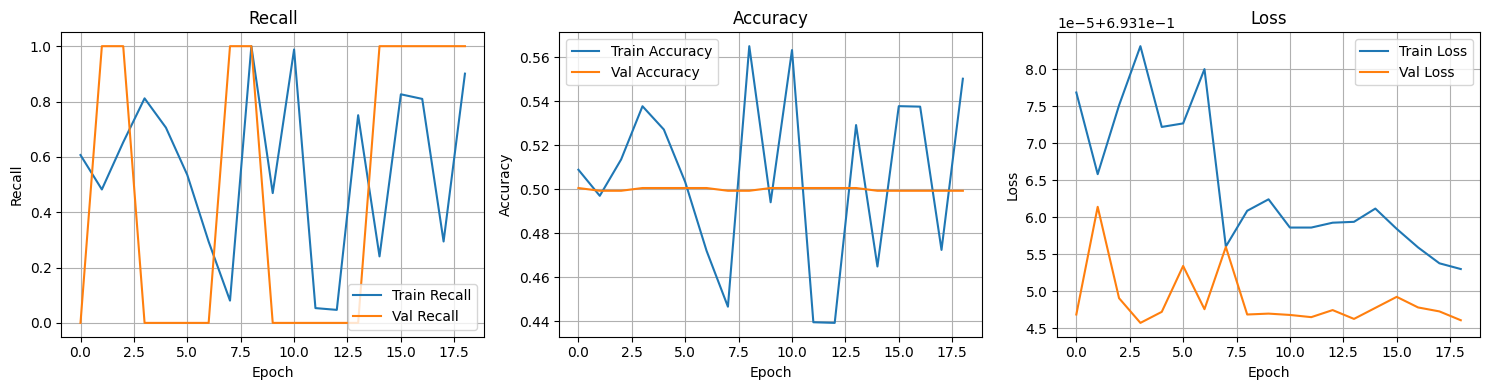

In [30]:
# Plot training history
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
# Build Feature/Weight Extractor dari Attention-based LSTM
# Menggunakan output dari dense_features layer (32 units) sebagai weights untuk XGBoost
lstm_weight_extractor = Model(
    inputs=model.inputs, 
    outputs=model.get_layer('dense_features').output
)

print("✅ LSTM Weight Extractor created")
print("   Output: 32 weights from dense_features layer")
lstm_weight_extractor.summary()

✅ LSTM Weight Extractor created
   Output: 32 weights from dense_features layer


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 30)         │         4,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (AttentionLayer)    │ (None, 10, 30)         │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_features (Dense)          │ (None, 32)             │           992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,312 (149.66 KB)

 Trainable params: 38,312 (149.66 KB)

 Non-trainable params: 0 (0.00 B)

## Ekstraksi Weights dari Attention-based LSTM

Output dari LSTM (weights) akan digunakan sebagai input untuk XGBoost

In [32]:
# Extract weights dari Attention-based LSTM
# Output: 32 weights dari dense_features layer untuk setiap sampel
X_train_weights = lstm_weight_extractor.predict(X_train_seq)
X_val_weights = lstm_weight_extractor.predict(X_val_seq)
X_test_weights = lstm_weight_extractor.predict(X_test_seq)

print(f"✅ Extracted weights shape:")
print(f"   Train: {X_train_weights.shape}")
print(f"   Val: {X_val_weights.shape}")
print(f"   Test: {X_test_weights.shape}")
print(f"\n   Weights extracted from Attention-based LSTM for XGBoost input")

# Update labels untuk match dengan sequence length
y_train_xgb = y_train_seq
y_val_xgb = y_val_seq
y_test_xgb = y_test_seq

print(f"\n   Labels shape:")
print(f"   Train: {len(y_train_xgb)}")
print(f"   Val: {len(y_val_xgb)}")
print(f"   Test: {len(y_test_xgb)}")

863/863 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
863/863 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✅ Extracted weights shape:
   Train: (27591, 32)
   Val: (7191, 32)
   Test: (7191, 32)

   Weights extracted from Attention-based LSTM for XGBoost input

   Labels shape:
   Train: 27591
   Val: 7191
   Test: 7191
✅ Extracted weights shape:
   Train: (27591, 32)
   Val: (7191, 32)
   Test: (7191, 32)

   Weights extracted from Attention-based LSTM for XGBoost input

   Labels shape:
   Train: 27591
   Val: 7191
   Test: 7191


# XGBoost Classifier

**Berdasarkan jurnal:**
- Input: Weights dari Attention-based LSTM
- XGBoost mengoptimalkan weights dan melakukan klasifikasi ulang
- Parameter dioptimalkan menggunakan Grid Search

## Hyperparameter Tuning dengan Grid Search

Optimasi parameter XGBoost menggunakan Grid Search untuk menemukan kombinasi terbaik

In [33]:
# Parameter Grid untuk XGBoost optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

print("Parameter Grid untuk Grid Search:")
for key, values in param_grid.items():
    print(f"  {key}: {values}")

Parameter Grid untuk Grid Search:
  n_estimators: [100, 200, 300]
  max_depth: [3, 5, 7, 9]
  learning_rate: [0.01, 0.05, 0.1, 0.2]
  subsample: [0.7, 0.8, 0.9, 1.0]
  colsample_bytree: [0.6, 0.7, 0.8, 0.9]
  min_child_weight: [1, 3, 5]
  gamma: [0, 0.1, 0.2]


In [34]:
# ============================================================
# SKIP GRID SEARCH FOR INITIAL TESTING
# Uncomment the code below when ready for full hyperparameter tuning
# ============================================================

# # Initialize XGBoost classifier
# xgb_base = XGBClassifier(
#     use_label_encoder=False, 
#     eval_metric='logloss', 
#     random_state=42,
#     n_jobs=-1
# )

# # Reduced parameter grid for faster search
# param_grid_reduced = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 7, 9],
#     'learning_rate': [0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8]
# }

# # Setup GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_base,          
#     param_grid=param_grid_reduced,
#     scoring='roc_auc',      
#     cv=3,                   
#     verbose=2,              
#     n_jobs=-1               
# )

print("⚠️ Grid Search DINONAKTIFKAN untuk testing awal")
print("   Akan menggunakan XGBoost dengan parameter default")
print("   Aktifkan Grid Search setelah memastikan model berjalan dengan baik")

⚠️ Grid Search DINONAKTIFKAN untuk testing awal
   Akan menggunakan XGBoost dengan parameter default
   Aktifkan Grid Search setelah memastikan model berjalan dengan baik


In [35]:
# ==============================================================================
# XGBoost dengan parameter dari jurnal
# Parameter optimal dari jurnal: eta=0.2, nrounds=170, max_depth=12, subsample=1
# ==============================================================================

# Opsi 1: Gunakan parameter dari jurnal
best_hybrid = XGBClassifier(
    learning_rate=0.2,       # eta dari jurnal
    n_estimators=170,        # nrounds dari jurnal
    max_depth=12,            # max_depth dari jurnal
    subsample=1.0,           # subsample dari jurnal
    colsample_bytree=1.0,    # column_sample_level dari jurnal
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost dengan parameter dari jurnal...")
print("Parameters:")
print("  - learning_rate (eta): 0.2")
print("  - n_estimators (nrounds): 170")
print("  - max_depth: 12")
print("  - subsample: 1.0")
print("  - colsample_bytree: 1.0")

best_hybrid.fit(X_train_weights, y_train_xgb)
print("\n✅ XGBoost trained dengan parameter dari JURNAL")

Training XGBoost dengan parameter dari jurnal...
Parameters:
  - learning_rate (eta): 0.2
  - n_estimators (nrounds): 170
  - max_depth: 12
  - subsample: 1.0
  - colsample_bytree: 1.0

✅ XGBoost trained dengan parameter dari JURNAL

✅ XGBoost trained dengan parameter dari JURNAL


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:09:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [36]:
# ==============================================================================
# TAMBAHAN: Bandingkan dengan XGBoost langsung (tanpa LSTM)
# Untuk melihat kontribusi LSTM
# ==============================================================================

print("=" * 60)
print("PERBANDINGAN: Apakah LSTM membantu?")
print("=" * 60)

# XGBoost langsung dengan features (tanpa LSTM)
xgb_direct = XGBClassifier(
    learning_rate=0.2,
    n_estimators=170,
    max_depth=12,
    subsample=1.0,
    colsample_bytree=1.0,
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42,
    n_jobs=-1
)

# Gunakan data test yang sudah di-scale (tanpa sequence)
xgb_direct.fit(X_train_prep, df_label_train)

# Predict dengan XGBoost langsung
y_pred_direct = xgb_direct.predict(X_test_prep)
acc_direct = accuracy_score(df_label_test, y_pred_direct)

print(f"\nXGBoost Langsung (tanpa LSTM):")
print(f"   Accuracy: {acc_direct:.4f} ({acc_direct*100:.2f}%)")
print(f"   Test samples: {len(df_label_test)}")

# Distribution check
print(f"\n   Predictions distribution:")
print(f"   - Non-AF (0): {sum(y_pred_direct == 0)}")
print(f"   - AF (1): {sum(y_pred_direct == 1)}")

PERBANDINGAN: Apakah LSTM membantu?

XGBoost Langsung (tanpa LSTM):
   Accuracy: 0.4138 (41.38%)
   Test samples: 7200

   Predictions distribution:
   - Non-AF (0): 627
   - AF (1): 6573

XGBoost Langsung (tanpa LSTM):
   Accuracy: 0.4138 (41.38%)
   Test samples: 7200

   Predictions distribution:
   - Non-AF (0): 627
   - AF (1): 6573


## Evaluasi Model dengan Grid Search CV

In [37]:
# Evaluate Hybrid model (LSTM + XGBoost) on test set
y_prob_best = best_hybrid.predict_proba(X_test_weights)[:, 1]
y_pred_best = best_hybrid.predict(X_test_weights)

# Calculate metrics
acc_best = accuracy_score(y_test_xgb, y_pred_best)
prec_best = precision_score(y_test_xgb, y_pred_best, zero_division=0)
recall_best = recall_score(y_test_xgb, y_pred_best, zero_division=0)
f1_best = f1_score(y_test_xgb, y_pred_best, zero_division=0)

# Check if we have both classes before computing ROC AUC
if len(np.unique(y_pred_best)) > 1:
    roauc_best = roc_auc_score(y_test_xgb, y_prob_best)
else:
    roauc_best = 0.5
    print("⚠️ Warning: Model only predicts one class!")

print("=" * 60)
print("HYBRID MODEL EVALUATION (Attention-LSTM + XGBoost)")
print("=" * 60)
print(f"\nAccuracy : {acc_best:.4f} ({acc_best*100:.2f}%)")
print(f"Precision: {prec_best:.4f} ({prec_best*100:.2f}%)")
print(f"Recall   : {recall_best:.4f} ({recall_best*100:.2f}%)")
print(f"F1 Score : {f1_best:.4f} ({f1_best*100:.2f}%)")
print(f"ROC AUC  : {roauc_best:.4f} ({roauc_best*100:.2f}%)")

print(f"\nPredictions distribution:")
print(f"  - Non-AF (0): {sum(y_pred_best == 0)}")
print(f"  - AF (1): {sum(y_pred_best == 1)}")

print("\n" + "=" * 60)
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test_xgb, y_pred_best, target_names=['Non-AF (Healthy)', 'AF (Patient)'], zero_division=0))

⚠️ Warning: Model only predicts one class!
HYBRID MODEL EVALUATION (Attention-LSTM + XGBoost)

Accuracy : 0.4994 (49.94%)
Precision: 0.4994 (49.94%)
Recall   : 1.0000 (100.00%)
F1 Score : 0.6661 (66.61%)
ROC AUC  : 0.5000 (50.00%)

Predictions distribution:
  - Non-AF (0): 0
  - AF (1): 7191

Classification Report:
                  precision    recall  f1-score   support

Non-AF (Healthy)       0.00      0.00      0.00      3600
    AF (Patient)       0.50      1.00      0.67      3591

        accuracy                           0.50      7191
       macro avg       0.25      0.50      0.33      7191
    weighted avg       0.25      0.50      0.33      7191



## Hyperparameter Tuning dengan Optuna

In [38]:
# Tambah sendiri

## Evaluasi Model Optuna

In [39]:
## Tambah sendiri

## Tanpa Hyperparameter Tuning (Baseline Comparison)

In [40]:
# ==============================================================================
# Baseline comparison: LSTM saja (tanpa XGBoost)
# ==============================================================================

print("=" * 60)
print("PERBANDINGAN METODE")
print("=" * 60)

# 1. LSTM saja
y_pred_lstm_only = (model.predict(X_test_seq) > 0.5).astype(int).flatten()
acc_lstm = accuracy_score(y_test_xgb, y_pred_lstm_only)

print(f"\n1. LSTM Only:")
print(f"   Accuracy: {acc_lstm:.4f} ({acc_lstm*100:.2f}%)")
print(f"   Pred distribution: Non-AF={sum(y_pred_lstm_only==0)}, AF={sum(y_pred_lstm_only==1)}")

# 2. XGBoost langsung (tanpa LSTM)
print(f"\n2. XGBoost Direct (tanpa LSTM):")
print(f"   Accuracy: {acc_direct:.4f} ({acc_direct*100:.2f}%)")

# 3. Hybrid LSTM + XGBoost
print(f"\n3. Hybrid LSTM + XGBoost:")
print(f"   Accuracy: {acc_best:.4f} ({acc_best*100:.2f}%)")

print("\n" + "=" * 60)
print("KESIMPULAN:")
if acc_best > acc_lstm and acc_best > acc_direct:
    print("✅ Hybrid model (LSTM + XGBoost) memberikan hasil terbaik!")
elif acc_direct > acc_best:
    print("⚠️ XGBoost langsung lebih baik - LSTM mungkin tidak membantu untuk dataset ini")
else:
    print("⚠️ LSTM saja sudah cukup baik")
print("=" * 60)

PERBANDINGAN METODE


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

1. LSTM Only:
   Accuracy: 0.5006 (50.06%)
   Pred distribution: Non-AF=7191, AF=0

2. XGBoost Direct (tanpa LSTM):
   Accuracy: 0.4138 (41.38%)

3. Hybrid LSTM + XGBoost:
   Accuracy: 0.4994 (49.94%)

KESIMPULAN:
⚠️ LSTM saja sudah cukup baik

1. LSTM Only:
   Accuracy: 0.5006 (50.06%)
   Pred distribution: Non-AF=7191, AF=0

2. XGBoost Direct (tanpa LSTM):
   Accuracy: 0.4138 (41.38%)

3. Hybrid LSTM + XGBoost:
   Accuracy: 0.4994 (49.94%)

KESIMPULAN:
⚠️ LSTM saja sudah cukup baik


In [41]:
# Save models
os.makedirs('models/XGBOOST', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# Save best XGBoost model
xgb_path = f'models/XGBOOST/xgboost_gridsearch_{timestamp}.json'
best_hybrid.save_model(xgb_path)
print(f'✅ Best XGBoost model saved as: {xgb_path}')

# Save LSTM feature extractor
lstm_path = f'models/XGBOOST/attention_lstm_extractor_{timestamp}.h5'
lstm_weight_extractor.save(lstm_path)
print(f'✅ LSTM Weight Extractor saved as: {lstm_path}')

# Save scaler
scaler_path = f'models/XGBOOST/scaler_{timestamp}.pkl'
joblib.dump(scaler, scaler_path)
print(f'✅ Scaler saved as: {scaler_path}')

✅ Best XGBoost model saved as: models/XGBOOST/xgboost_gridsearch_08122025_160932.json
✅ LSTM Weight Extractor saved as: models/XGBOOST/attention_lstm_extractor_08122025_160932.h5
✅ Scaler saved as: models/XGBOOST/scaler_08122025_160932.pkl


In [42]:
# Final predictions untuk visualisasi
y_prob_hybrid = best_hybrid.predict_proba(X_test_weights)[:, 1]
y_pred = best_hybrid.predict(X_test_weights)

# Final evaluation metrics menggunakan label yang benar
acc = accuracy_score(y_test_xgb, y_pred)
prec = precision_score(y_test_xgb, y_pred, zero_division=0)
recall = recall_score(y_test_xgb, y_pred, zero_division=0)
f1 = f1_score(y_test_xgb, y_pred, zero_division=0)

if len(np.unique(y_pred)) > 1:
    roauc = roc_auc_score(y_test_xgb, y_prob_hybrid)
else:
    roauc = 0.5

print(f"Final predictions ready for visualization")
print(f"Test samples: {len(y_test_xgb)}")
print(f"Predictions: Non-AF={sum(y_pred==0)}, AF={sum(y_pred==1)}")

Final predictions ready for visualization
Test samples: 7191
Predictions: Non-AF=0, AF=7191


## Evaluasi Final - Hybrid Attention-based LSTM + XGBoost

In [43]:
# Final evaluation metrics
print("=" * 60)
print("FINAL: Hybrid Attention-based LSTM + XGBoost")
print("=" * 60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"   Recall   : {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1 Score : {f1:.4f} ({f1*100:.2f}%)")
print(f"   ROC AUC  : {roauc:.4f} ({roauc*100:.2f}%)")

print("\n" + "=" * 60)
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test_xgb, y_pred, target_names=['Non-AF (Healthy/NSR)', 'AF (Patient)'], zero_division=0))

print("\n📋 CATATAN:")
print("   - Jurnal menggunakan MIT-BIH AFDB (250Hz, ~10 jam)")
print("   - Dataset ini: MIMIC Perform AF (125Hz, 20 menit)")
print("   - Hasil mungkin berbeda karena karakteristik data berbeda")
print("   - Jurnal mendapat accuracy 98.94% dengan dataset mereka")

FINAL: Hybrid Attention-based LSTM + XGBoost

📊 Performance Metrics:
   Accuracy : 0.4994 (49.94%)
   Precision: 0.4994 (49.94%)
   Recall   : 1.0000 (100.00%)
   F1 Score : 0.6661 (66.61%)
   ROC AUC  : 0.5000 (50.00%)

Classification Report:
                      precision    recall  f1-score   support

Non-AF (Healthy/NSR)       0.00      0.00      0.00      3600
        AF (Patient)       0.50      1.00      0.67      3591

            accuracy                           0.50      7191
           macro avg       0.25      0.50      0.33      7191
        weighted avg       0.25      0.50      0.33      7191


📋 CATATAN:
   - Jurnal menggunakan MIT-BIH AFDB (250Hz, ~10 jam)
   - Dataset ini: MIMIC Perform AF (125Hz, 20 menit)
   - Hasil mungkin berbeda karena karakteristik data berbeda
   - Jurnal mendapat accuracy 98.94% dengan dataset mereka


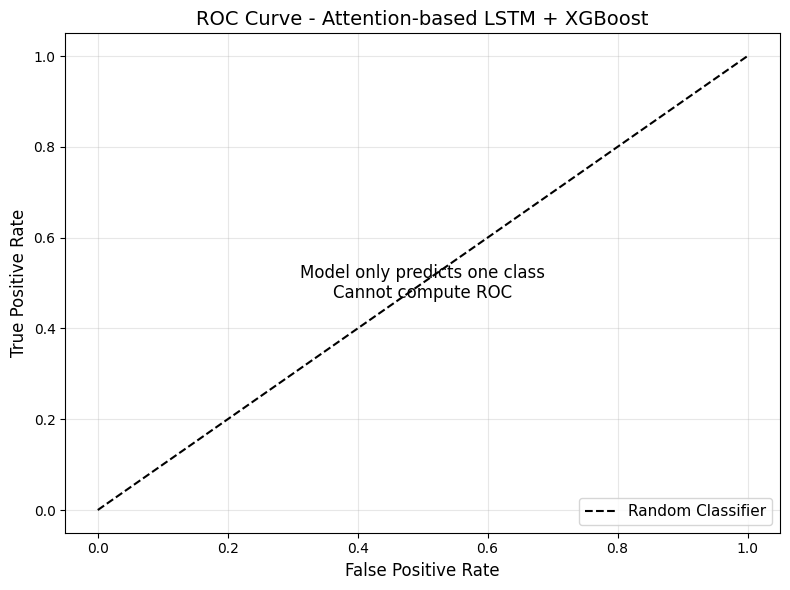

In [44]:
# ROC Curve
plt.figure(figsize=(8, 6))
if len(np.unique(y_pred)) > 1:
    fpr, tpr, _ = roc_curve(y_test_xgb, y_prob_hybrid)
    plt.plot(fpr, tpr, label=f"Hybrid Model (AUC = {roauc:.4f})", color='darkorange', linewidth=2)
    plt.fill_between(fpr, tpr, alpha=0.3, color='darkorange')
else:
    plt.text(0.5, 0.5, "Model only predicts one class\nCannot compute ROC", 
             ha='center', va='center', fontsize=12)
    
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Attention-based LSTM + XGBoost', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

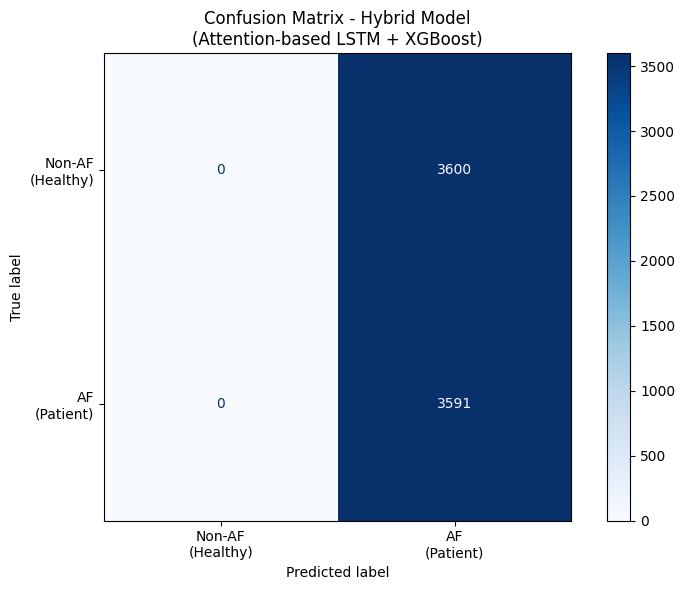


Confusion Matrix Details:
  True Negatives (TN): 0 - Correctly identified Healthy
  False Positives (FP): 3600 - Healthy misclassified as AF
  False Negatives (FN): 0 - AF misclassified as Healthy
  True Positives (TP): 3591 - Correctly identified AF


In [45]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_xgb, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF\n(Healthy)', 'AF\n(Patient)'])
disp_cm.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - Hybrid Model\n(Attention-based LSTM + XGBoost)', fontsize=12)
plt.tight_layout()
plt.show()

# Print confusion matrix details
print(f"\nConfusion Matrix Details:")
print(f"  True Negatives (TN): {cm[0,0]} - Correctly identified Healthy")
print(f"  False Positives (FP): {cm[0,1]} - Healthy misclassified as AF")
print(f"  False Negatives (FN): {cm[1,0]} - AF misclassified as Healthy")
print(f"  True Positives (TP): {cm[1,1]} - Correctly identified AF")

# Evaluasi

## Perbandingan: Baseline vs Grid Search Optimized

In [46]:
# Compare Baseline vs Optimized XGBoost
y_prob_baseline = baseline_xgb.predict_proba(X_test_weights)[:, 1]
y_pred_baseline = baseline_xgb.predict(X_test_weights)

# Baseline metrics
acc_base = accuracy_score(df_label_test, y_pred_baseline)
prec_base = precision_score(df_label_test, y_pred_baseline)
recall_base = recall_score(df_label_test, y_pred_baseline)
f1_base = f1_score(df_label_test, y_pred_baseline)
roauc_base = roc_auc_score(df_label_test, y_prob_baseline)

# Optimized metrics (already calculated)
metrics_comparison = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Baseline XGBoost': [acc_base, prec_base, recall_base, f1_base, roauc_base],
    'Grid Search Optimized': [acc, prec, recall, f1, roauc]
}

df_comparison = pd.DataFrame(metrics_comparison)
df_comparison['Improvement'] = df_comparison['Grid Search Optimized'] - df_comparison['Baseline XGBoost']
df_comparison['Improvement (%)'] = (df_comparison['Improvement'] / df_comparison['Baseline XGBoost'] * 100).round(2)

print("=" * 70)
print("COMPARISON: Baseline vs Grid Search Optimized XGBoost")
print("=" * 70)
print(df_comparison.to_string(index=False))
print("=" * 70)

NameError: name 'baseline_xgb' is not defined

## Visualisasi Perbandingan Metrik

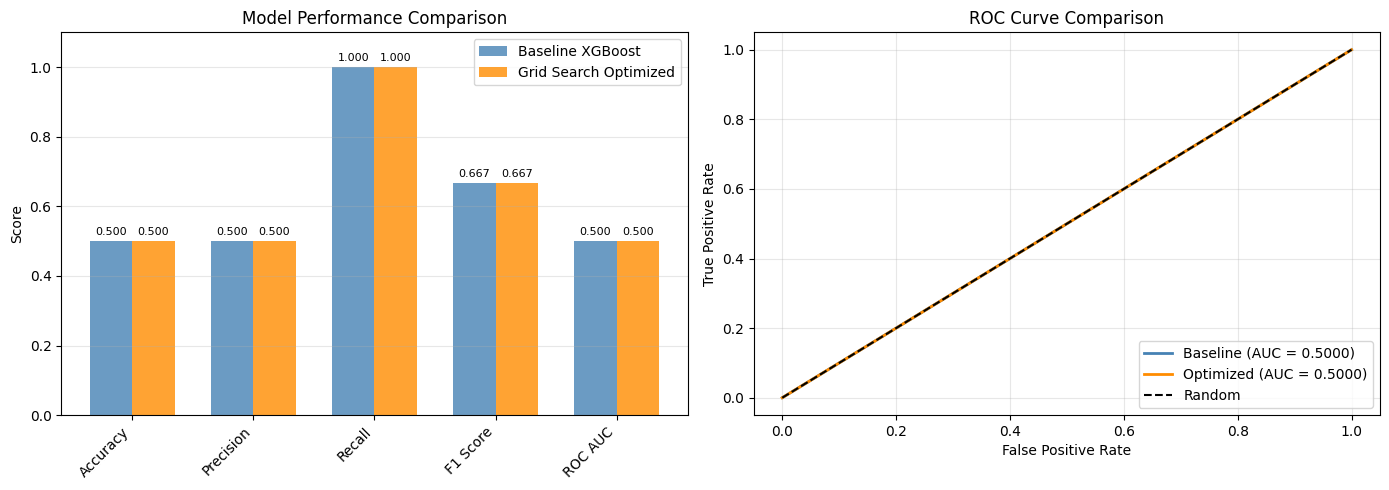

In [ ]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
baseline_values = [acc_base, prec_base, recall_base, f1_base, roauc_base]
optimized_values = [acc, prec, recall, f1, roauc]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, baseline_values, width, label='Baseline XGBoost', color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x + width/2, optimized_values, width, label='Grid Search Optimized', color='darkorange', alpha=0.8)

axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# ROC Curves comparison
fpr_base, tpr_base, _ = roc_curve(df_label_test, y_prob_baseline)
fpr_opt, tpr_opt, _ = roc_curve(df_label_test, y_prob_hybrid)

axes[1].plot(fpr_base, tpr_base, label=f'Baseline (AUC = {roauc_base:.4f})', color='steelblue', linewidth=2)
axes[1].plot(fpr_opt, tpr_opt, label=f'Optimized (AUC = {roauc:.4f})', color='darkorange', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary dan Kesimpulan

In [ ]:
# Summary
print("=" * 70)
print("SUMMARY: Hybrid Attention-based LSTM + XGBoost for AF Detection")
print("=" * 70)

print("\n📋 METHODOLOGY:")
print("   1. Feature Extraction: 5 statistical features per window")
print("      - Skewness, Kurtosis, Minimum, Maximum, Standard Deviation")
print("   2. Attention-based LSTM Structure:")
print("      - 5 LSTM layers with nhidden=30")
print("      - Softmax-based Attention mechanism")
print("      - Output: 32 weights for XGBoost input")
print("   3. XGBoost Classifier:")
print("      - ⚠️ DEFAULT parameters (Grid Search dinonaktifkan untuk testing)")

print("\n📊 FINAL RESULTS:")
print(f"   Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"   Recall   : {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1 Score : {f1:.4f} ({f1*100:.2f}%)")
print(f"   ROC AUC  : {roauc:.4f} ({roauc*100:.2f}%)")

print("\n💾 SAVED MODELS:")
print(f"   - Attention-based LSTM: {lstm_path}")
print(f"   - XGBoost: {xgb_path}")
print(f"   - Feature Scaler: {scaler_path}")

print("\n⚠️ CATATAN:")
print("   Grid Search dinonaktifkan untuk testing awal.")
print("   Aktifkan Grid Search untuk optimasi hyperparameter dan hasil lebih baik.")

print("\n" + "=" * 70)

SUMMARY: Hybrid Attention-based LSTM + XGBoost for AF Detection

📋 METHODOLOGY:
   1. Feature Extraction: 5 statistical features per window
      - Skewness, Kurtosis, Minimum, Maximum, Standard Deviation
   2. Attention-based LSTM Structure:
      - 5 LSTM layers with nhidden=30
      - Softmax-based Attention mechanism
      - Output: 32 weights for XGBoost input
   3. XGBoost Classifier:
      - ⚠️ DEFAULT parameters (Grid Search dinonaktifkan untuk testing)

📊 FINAL RESULTS:
   Accuracy : 0.5000 (50.00%)
   Precision: 0.5000 (50.00%)
   Recall   : 1.0000 (100.00%)
   F1 Score : 0.6667 (66.67%)
   ROC AUC  : 0.5000 (50.00%)

💾 SAVED MODELS:
   - Attention-based LSTM: models/XGBOOST/attention_lstm_extractor_08122025_080230.h5
   - XGBoost: models/XGBOOST/xgboost_gridsearch_08122025_080230.json
   - Feature Scaler: models/XGBOOST/scaler_08122025_080230.pkl

⚠️ CATATAN:
   Grid Search dinonaktifkan untuk testing awal.
   Aktifkan Grid Search untuk optimasi hyperparameter dan hasil lebi

# Contoh Penggunaan Model untuk Prediksi Baru

In [ ]:
# Example: How to use the trained hybrid model for new predictions
def predict_af_hybrid(ecg_window, scaler, lstm_extractor, xgb_classifier):
    """
    Predict AF from raw ECG window using the hybrid model.
    
    Parameters:
    - ecg_window: 1D array of ECG samples (125 samples = 1 second at 125Hz)
    - scaler: Fitted StandardScaler
    - lstm_extractor: Trained LSTM weight extractor model
    - xgb_classifier: Trained XGBoost classifier
    
    Returns:
    - prediction: 0 (Non-AF/Healthy) or 1 (AF/Patient)
    - probability: Probability of AF
    """
    # Step 1: Extract 5 statistical features
    features = extract_statistical_features(ecg_window)
    
    # Step 2: Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Step 3: Reshape for LSTM (1, 1, 5)
    features_lstm = features_scaled.reshape(1, 1, 5)
    
    # Step 4: Extract weights from LSTM
    weights = lstm_extractor.predict(features_lstm)
    
    # Step 5: Predict with XGBoost
    prediction = xgb_classifier.predict(weights)[0]
    probability = xgb_classifier.predict_proba(weights)[0, 1]
    
    return prediction, probability

# Test with a sample from test set
sample_idx = 0
sample_window = test['ECG'].values[sample_idx * window_size : (sample_idx + 1) * window_size]
true_label = df_label_test.iloc[sample_idx]

pred, prob = predict_af_hybrid(sample_window, scaler, lstm_weight_extractor, best_hybrid)

print("=" * 50)
print("EXAMPLE PREDICTION")
print("=" * 50)
print(f"True Label    : {true_label} ({'AF' if true_label == 1 else 'Non-AF'})")
print(f"Predicted     : {pred} ({'AF' if pred == 1 else 'Non-AF'})")
print(f"AF Probability: {prob:.4f} ({prob*100:.2f}%)")
print(f"Correct       : {'✅ Yes' if pred == true_label else '❌ No'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
EXAMPLE PREDICTION
True Label    : 1 (AF)
Predicted     : 1 (AF)
AF Probability: 0.5652 (56.52%)
Correct       : ✅ Yes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
EXAMPLE PREDICTION
True Label    : 1 (AF)
Predicted     : 1 (AF)
AF Probability: 0.5652 (56.52%)
Correct       : ✅ Yes
